# Non-linear offset-free MPC

In this notebook, we will design an offset-free model predictive control (MPC) for a heat exchanger using noisy output measurements. In contrast to the nonlinear tracking MPC controller for the same system, we do no longer assume that we have complete and error-free access to system states and disturbances, or that the prediction model agrees perfectly with the true system dynamics (here represented by a simulation model). Instead, we use an extended Kalman filter to estimate the system states and disturbances, and we use slightly different model parameters for the simulation model. Nevertheless, as we will see, the resulting controller is able to attain error-free tracking in face of system disturbances.

## Define the model parameters

We begin by defining the model parameters for the heat exchanger.


In [1]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from openmpc.NonlinearMPC import NonlinearSystem,trackingMPC, EKF, create_estimator_model

# Define the model parameters
C_hot = 5000  # Heat capacity of hot fluid (J/K)
C_cold = 5000  # Heat capacity of cold fluid (J/K)
c_p_hot = 2000  # Specific heat capacity of hot fluid (J/kg·K)
c_p_cold = 4184  # Specific heat capacity of cold fluid (J/kg·K)
U = 500  # Overall heat transfer coefficient (W/m²*K)
A = 50  # Heat transfer area (m²)

## Define the System States and Control Inputs

We will now define the system states and control inputs.


In [2]:
# Define the system states and control inputs
T_hot = ca.MX.sym('T_hot')
T_hot_in = ca.MX.sym('T_hot_in')
T_cold = ca.MX.sym('T_cold')
T_cold_in = ca.MX.sym('T_cold_in')
m_dot_hot = ca.MX.sym('m_dot_hot')
m_dot_cold = ca.MX.sym('m_dot_cold')

## Define the Prediction Model

Next, we define the prediction model for the heat exchanger.


In [3]:
# Define prediction model
samplingTime = 0.1

dT_hot = (1 / C_hot) * (m_dot_hot * c_p_hot * (T_hot_in - T_hot) - U * A * (T_hot - T_cold))
dT_cold = (1 / C_cold) * (m_dot_cold * c_p_cold * (T_cold_in - T_cold) + U * A * (T_hot - T_cold))

rhs = ca.vertcat(dT_hot, dT_cold)
states = ca.vertcat(T_hot, T_cold)
inputs = ca.vertcat(m_dot_hot, m_dot_cold)
disturbances = ca.vertcat(T_hot_in, T_cold_in)

# Create the NonlinearSystem object
heatExchangerSystem = NonlinearSystem(updfcn=rhs, states=states, inputs=inputs, disturbances=disturbances, outfcn=states)

# Define discrete-time prediction model
predictionModel=heatExchangerSystem.c2d(samplingTime)

## Define Disturbance Profiles and Desired Output

We define the disturbance profiles and the desired output temperatures for the heat exchanger.


In [4]:
# Define disturbance profiles
T_hot_in = 150  # Nominal inlet temperature of hot fluid (°C)
T_cold_in = 25  # Nominal inlet temperature of cold fluid (°C)

# Define desired outlet temperatures
T_hot_ref = 110  # Desired outlet temperature of hot fluid (°C)
T_cold_ref = 50  # Desired outlet temperature of cold fluid (°C)

## Define the MPC Controller

Now, we define the MPC controller using the prediction model and other parameters.



In [5]:
Q=np.diag([1, 1])
R=np.diag([0.1, 0.05])

# Compute the LQR controller and the corresponding Riccati solution
dnom = np.array([T_hot_in, T_cold_in])
yref = np.array([T_hot_ref, T_cold_ref])
(xref, uref) = predictionModel.get_target_point(yref, dnom)
L, P, _ = predictionModel.compute_lqr_controller(Q, R, (xref, uref, dnom))

mpcProblemData = {
    'N': 10,
    'dt': samplingTime,  # sampling time
    'Q': Q, 
    'R': R,
    'Q_N': P,
    'predictionModel': predictionModel,
    'umin': np.array([1, 1]),  # Control limits
    'umax': np.array([20, 30]),  # Control limits    
    'slackPenaltyWeight': 1e6,  # Slack penalty weight
    'baseController': L, 
    'dualModeHorizon': 5,  # Dual mode horizon
    'dualModeController': L
}


# Initialize the MPC controller
mpc = trackingMPC(mpcProblemData)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



## Define the Simulation Model

We define the simulation model for the heat exchanger. Note that in this case, we use slightly different `c_p` values.


In [6]:
def createSimulationModel():
    """
    Create the simulation model with system dynamics.

    Returns:
    NonlinearSystem: A NonlinearSystem object representing the simulation model.
    """
    # Define the system dynamics for the simulation model
    T_hot = ca.MX.sym('T_hot')
    T_cold = ca.MX.sym('T_cold')
    m_dot_hot = ca.MX.sym('m_dot_hot')
    m_dot_cold = ca.MX.sym('m_dot_cold')
    T_hot_in = ca.MX.sym('T_hot_in')
    T_cold_in = ca.MX.sym('T_cold_in')

    # Define the model parameters
    C_hot = 5000  # Heat capacity of hot fluid (J/K)
    C_cold = 5000  # Heat capacity of cold fluid (J/K)
    c_p_hot = 2500  # Specific heat capacity of hot fluid (J/kg·K)
    c_p_cold = 4000  # Specific heat capacity of cold fluid (J/kg·K)
    U = 500  # Overall heat transfer coefficient (W/m²*K)
    A = 50  # Heat transfer area (m²)

    # Define the system dynamics
    dT_hot = (1 / C_hot) * (m_dot_hot * c_p_hot * (T_hot_in - T_hot) - U * A * (T_hot - T_cold))
    dT_cold = (1 / C_cold) * (m_dot_cold * c_p_cold * (T_cold_in - T_cold) + U * A * (T_hot - T_cold))

    rhs = ca.vertcat(
        dT_hot,           # dT_hot/dt
        dT_cold           # dT_cold/dt
    )

    # Define state, input, and disturbance vectors
    x = ca.vertcat(T_hot, T_cold)
    u = ca.vertcat(m_dot_hot, m_dot_cold)
    d = ca.vertcat(T_hot_in, T_cold_in)

    # Create the NonlinearSystem object
    simulationModel = NonlinearSystem(updfcn=rhs, states=x, inputs=u, disturbances=d)

    return simulationModel

# Create the simulation model
simulationModel = createSimulationModel().c2d(samplingTime)


## Define the EKF (Extended Kalman Filter)

We define the EKF for state and disturbance estimation using the prediction model.


In [7]:
estimatorModel=create_estimator_model(predictionModel)

# Define the initial state and covariance estimates
xe0 = np.array([120, 50, 120, 50])  # Initial state [T_hot, T_cold, T_hot_in, T_cold_in]
P0 = 1000*np.eye(4)  # Initial state covariance

# Define the process noise and measurement noise covariance matrices
Qnoise = np.diag([0.001, 0.001, 0.001, 0.001])  # Process noise covariance
Rnoise = np.diag([0.01, 0.01])  # Measurement noise covariance

# Pack the EKF parameters into a struct
ekfParameters = {
    'predictionModel': estimatorModel,
    'Q': Qnoise,
    'R': Rnoise,
    'x0': xe0,
    'P0': P0,
    'dt': samplingTime  # Time step
}
ekf = EKF(ekfParameters)

@1=vertcat(T_hot, T_cold), @2=vertcat((0.0002*(((2000*m_dot_hot)*(T_hot_in-T_hot))-(25000*(T_hot-T_cold)))), (0.0002*(((4184*m_dot_cold)*(T_cold_in-T_cold))+(25000*(T_hot-T_cold))))), @3=vertcat(m_dot_hot, m_dot_cold), @4=vertcat(T_hot_in, T_cold_in), @5=updfcn((@1+(0.05*@2)), @3, @4){0}, @6=updfcn((@1+(0.05*@5)), @3, @4){0}, vertcat((@1+(0.0166667*(((@2+(2.*@5))+(2.*@6))+updfcn((@1+(0.1*@6)), @3, @4){0}))), T_hot_in, T_cold_in)
vertcat(T_hot, T_cold)


## Set Up Simulation

We will now set up the simulation environment and initialize the state and control trajectories for the simulation.


In [8]:
# Define the time step
dt = samplingTime  # Time step (hours)

# Create the Runge-Kutta integrator for the simulation model
#sim_integrator = RK(simulationModel, dt, order=4)

# Simulation time
Tsim = 20  # Final time (hours)
time = np.arange(0, Tsim, dt)

# Define the initial conditions
T_hot_0 = 120  # Initial temperature of hot fluid (°C)
T_cold_0 = 40  # Initial temperature of cold fluid (°C)



## Run the Simulation

We run the simulation loop, update the EKF with the new measurements, and compute the control actions using the MPC.


In [9]:
# Initial state
x0 = np.array([T_hot_ref, T_cold_ref])
yref = np.array([T_hot_ref, T_cold_ref])
d = np.array([T_hot_in, T_cold_in])

# Initialize state and control trajectories for simulation
x_sim = [x0]
u_sim = []

x_hat = xe0
n = len(x0)

for k in range(len(time)):
    x_current = x_sim[-1]
    x_hat = ekf.get_state()
    
    if time[k] > 5:
        d[1] = T_cold_in + 5

    if time[k] > 10:
        yref[0] = T_hot_ref - 10
    
    try:
        u_current = mpc.get_control_action(x_hat[0:n], yref, x_hat[n:])
    except Exception as e:
        print(f"Error at simulation step {k}: {e}")
        break

    # Integrate the state using the simulation model
    x_next = simulationModel.updfcn(x_current, u_current, d).full().flatten()
     
    # Simulate a measurement
    y_meas = np.array([x_next[0], x_next[1]]) + np.random.multivariate_normal(np.zeros(2), ekf.R)
    
    # Update the EKF with the new measurement
    ekf.prediction_update(u_current)
    ekf.measurement_update(y_meas, u_current)

    # Store the control action and the next state
    u_sim.append(u_current)
    x_sim.append(x_next)

    # Print status every hour of simulation time
    if (k + 1) % int(1 / dt) == 0:
        sim_time = (k + 1) * dt
        print(f"Simulation time: {sim_time:.2f} hours. Current system state: {x_next}")

# Convert simulation results to numpy arrays for easier manipulation
x_sim = np.array(x_sim)
u_sim = np.array(u_sim)

Simulation time: 1.00 hours. Current system state: [110.21599274  50.05805603]
Simulation time: 2.00 hours. Current system state: [110.04862294  49.9560381 ]
Simulation time: 3.00 hours. Current system state: [110.01991618  50.01125102]
Simulation time: 4.00 hours. Current system state: [110.03106704  50.03646924]
Simulation time: 5.00 hours. Current system state: [110.00193858  50.0636543 ]
Simulation time: 6.00 hours. Current system state: [110.09959037  50.67064108]
Simulation time: 7.00 hours. Current system state: [109.9972939   50.04894963]
Simulation time: 8.00 hours. Current system state: [109.92920285  49.92267578]
Simulation time: 9.00 hours. Current system state: [109.99970786  50.01205311]
Simulation time: 10.00 hours. Current system state: [110.05347974  49.98755069]
Simulation time: 11.00 hours. Current system state: [100.41486298  49.83709893]
Simulation time: 12.00 hours. Current system state: [100.16317004  49.91640337]
Simulation time: 13.00 hours. Current system stat

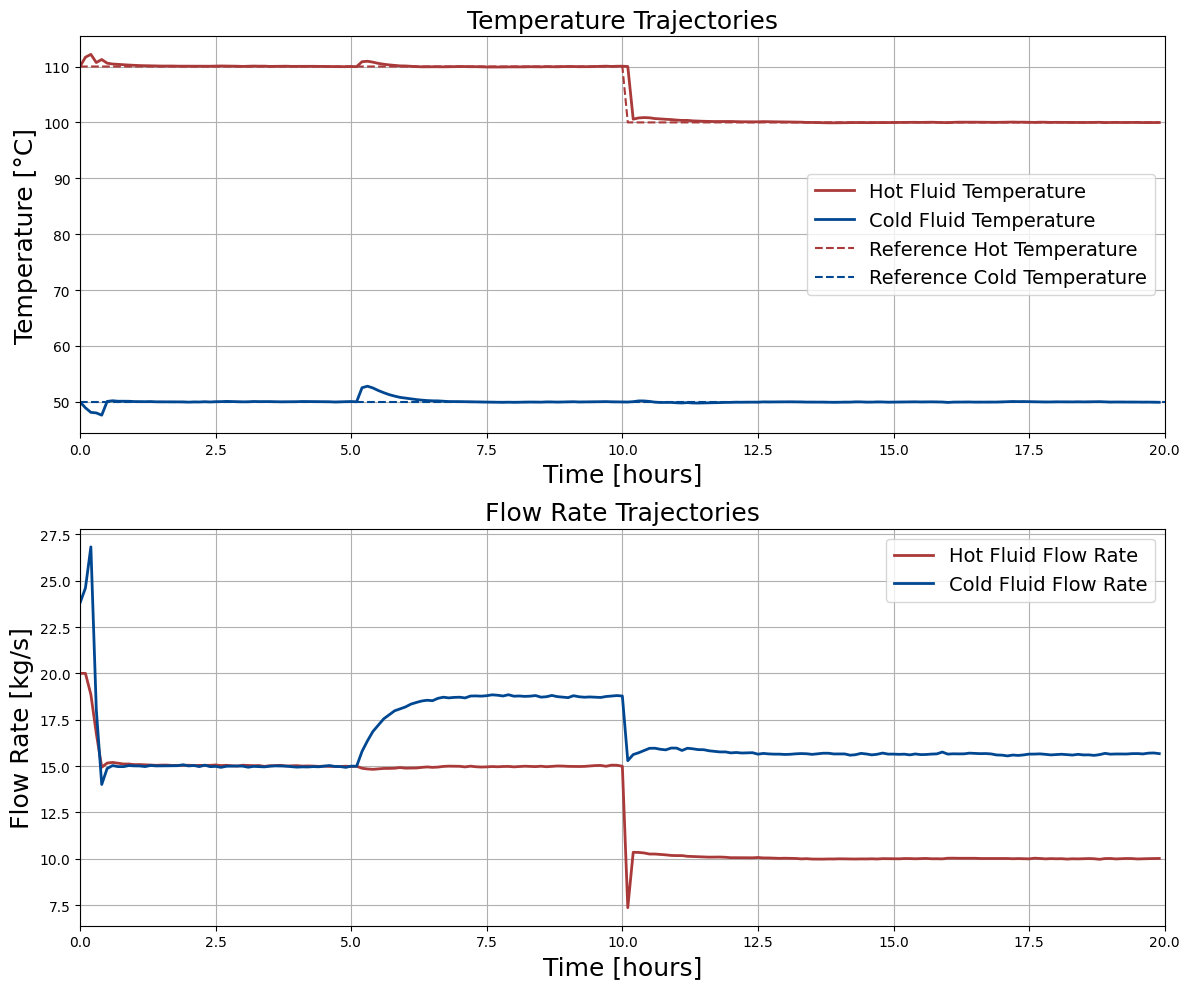

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure the simulation result arrays are numpy arrays for easier manipulation
x_sim_array = np.array(x_sim)
u_sim_array = np.array(u_sim)

# Time grid for plotting
t_sim = time

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot the state trajectories on the first subplot
ax1.plot(t_sim, x_sim_array[:-1, 0], label='Hot Fluid Temperature', color='#AA3939', linewidth=2)
ax1.plot(t_sim, x_sim_array[:-1, 1], label='Cold Fluid Temperature', color='#004791', linewidth=2)

# Update reference values to reflect the change at T = 10
T_hot_ref_updated = np.array([T_hot_ref if t <= 10 else T_hot_ref-10 for t in t_sim])
ax1.plot(t_sim, T_hot_ref_updated, color='#AA3939', linestyle='--', label='Reference Hot Temperature')
ax1.axhline(T_cold_ref, color='#004791', linestyle='--', label='Reference Cold Temperature')

# Set x-limits
ax1.set_xlim([0, Tsim])

# Set labels, title, and legend
ax1.set_xlabel('Time [hours]', fontsize=18)
ax1.set_ylabel('Temperature [°C]', fontsize=18)
ax1.legend(fontsize=14)
ax1.set_title('Temperature Trajectories', fontsize=18)
ax1.grid(True)

# Plot the control trajectories on the second subplot
ax2.plot(t_sim, u_sim_array[:, 0], label='Hot Fluid Flow Rate', color='#AA3939', linewidth=2)
ax2.plot(t_sim, u_sim_array[:, 1], label='Cold Fluid Flow Rate', color='#004791', linewidth=2)

# Set x-limits
ax2.set_xlim([0, Tsim])

# Set labels, title, and legend
ax2.set_xlabel('Time [hours]', fontsize=18)
ax2.set_ylabel('Flow Rate [kg/s]', fontsize=18)
ax2.legend(fontsize=14)
ax2.set_title('Flow Rate Trajectories', fontsize=18)
ax2.grid(True)

# Adjust layout and save the figure as a PDF
plt.tight_layout()
plt.savefig('heat_exchanger_simulation.pdf', format='pdf')

# Display the plot
plt.show()
